# Event Distribution and Trends

Analyze event type distribution, time ranges, and trends in e-commerce user behavior.


In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Try all available connection strings in order until one works
candidates = [
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=np:\\localhost\pipe\MSSQL$SQLEXPRESS\sql\query;DATABASE=Funnel_Purchases;Trusted_Connection=yes;",
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=(localdb)\\MSSQLLocalDB;DATABASE=Funnel_Purchases;Trusted_Connection=yes;",
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost\\SQLEXPRESS;DATABASE=Funnel_Purchases;UID=sa;PWD=YourPassword;",
]

def get_conn(timeout=30):
    for conn_str in candidates:
        try:
            conn = pyodbc.connect(conn_str, timeout=timeout)
            return conn
        except Exception:
            continue
    raise RuntimeError('All connection attempts failed')

In [2]:
# --- LOAD DATA IN CHUNKS (optimized query & chunk size) ---
# Only select needed columns for event distribution and trends
optimized_query = "SELECT event_time, event_type, category_code FROM dbo.[2019-Oct]"
conn = get_conn(timeout=60)
chunk_size = 100000  # Optimal for most modern systems, adjust if needed
chunk_iter = pd.read_sql(optimized_query, conn, chunksize=chunk_size)
parts = []
total = 0
for chunk in chunk_iter:
    parts.append(chunk)
    total += len(chunk)
    print(f"Fetched {total} rows so far")
conn.close()
df = pd.concat(parts, ignore_index=True)
print(f"Loaded {len(df)} rows from SQL (optimized, chunk_size={chunk_size}))")

C:\Users\asus\AppData\Local\Temp\ipykernel_14232\695668512.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  chunk_iter = pd.read_sql(optimized_query, conn, chunksize=chunk_size)


Fetched 100000 rows so far
Fetched 200000 rows so far
Fetched 200000 rows so far
Fetched 300000 rows so far
Fetched 300000 rows so far
Fetched 400000 rows so far
Fetched 400000 rows so far
Fetched 500000 rows so far
Fetched 500000 rows so far
Fetched 600000 rows so far
Fetched 600000 rows so far
Fetched 700000 rows so far
Fetched 700000 rows so far
Fetched 800000 rows so far
Fetched 800000 rows so far
Fetched 900000 rows so far
Fetched 900000 rows so far
Fetched 1000000 rows so far
Fetched 1000000 rows so far
Fetched 1100000 rows so far
Fetched 1100000 rows so far
Fetched 1200000 rows so far
Fetched 1200000 rows so far
Fetched 1300000 rows so far
Fetched 1300000 rows so far
Fetched 1400000 rows so far
Fetched 1400000 rows so far
Fetched 1500000 rows so far
Fetched 1500000 rows so far
Fetched 1600000 rows so far
Fetched 1600000 rows so far
Fetched 1700000 rows so far
Fetched 1700000 rows so far
Fetched 1800000 rows so far
Fetched 1800000 rows so far
Fetched 1900000 rows so far
Fetched 1

In [3]:
# --- Event Distribution ---
event_counts = df['event_type'].value_counts()
print('Event Distribution:')
print(event_counts)

# --- Time Range ---
min_time = df['event_time'].min()
max_time = df['event_time'].max()
print(f'Event Time Range: {min_time} to {max_time}')

# --- Top Categories ---
if 'category_code' in df.columns:
    top_categories = df['category_code'].value_counts().head(10)
    print('Top 10 Categories:')
    print(top_categories)
else:
    print('No category_code column found.')

Event Distribution:
event_type
view        40710876
cart          926366
purchase      742849
Name: count, dtype: int64
Event Time Range: 2019-10-01 00:00:00 to 2019-10-31 23:59:59
Top 10 Categories:
category_code
                                    13478561
electronics.smartphone              11502427
electronics.clocks                   1307985
computers.notebook                   1136040
electronics.video.tv                 1112724
electronics.audio.headphone          1099330
appliances.kitchen.refrigerators      887312
appliances.kitchen.washer             868890
appliances.environment.vacuum         800993
apparel.shoes                         761899
Name: count, dtype: int64
Top 10 Categories:
category_code
                                    13478561
electronics.smartphone              11502427
electronics.clocks                   1307985
computers.notebook                   1136040
electronics.video.tv                 1112724
electronics.audio.headphone          1099330
applian

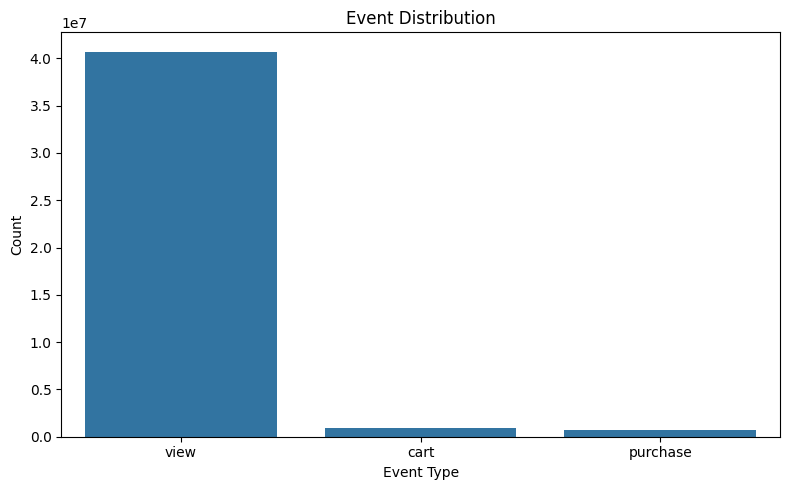

In [4]:
# --- Plot: Event Distribution ---
plt.figure(figsize=(8, 5))
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title('Event Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

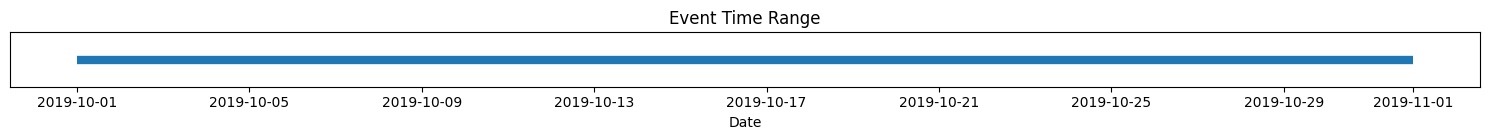

In [5]:
# --- Plot: Time Range ---
import matplotlib.dates as mdates
plt.figure(figsize=(15, 1.5))
plt.hlines(1, min_time, max_time, colors='tab:blue', lw=6)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Event Time Range')
plt.xlabel('Date')
plt.yticks([])
plt.tight_layout()
plt.show()

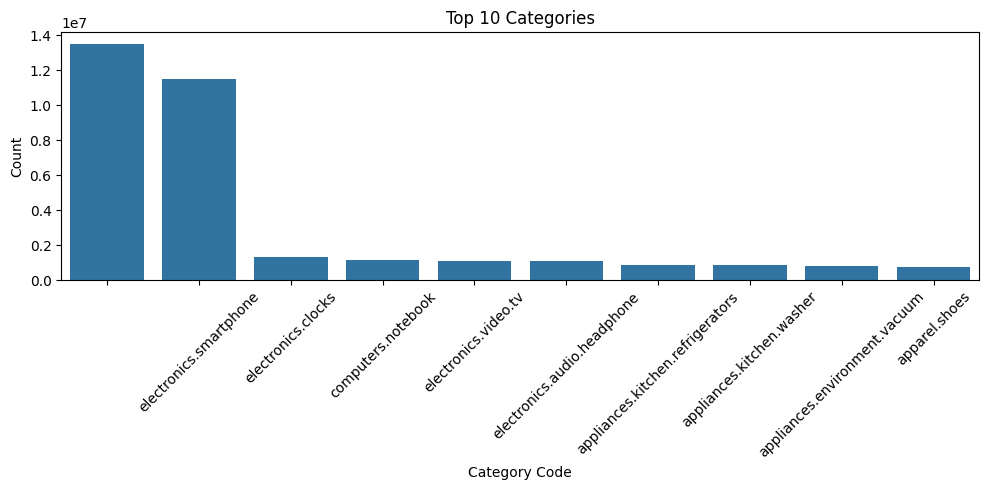

In [6]:
# --- Plot: Top 10 Categories ---
if 'category_code' in df.columns and not top_categories.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_categories.index, y=top_categories.values)
    plt.title('Top 10 Categories')
    plt.xlabel('Category Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('No category_code data to plot.')

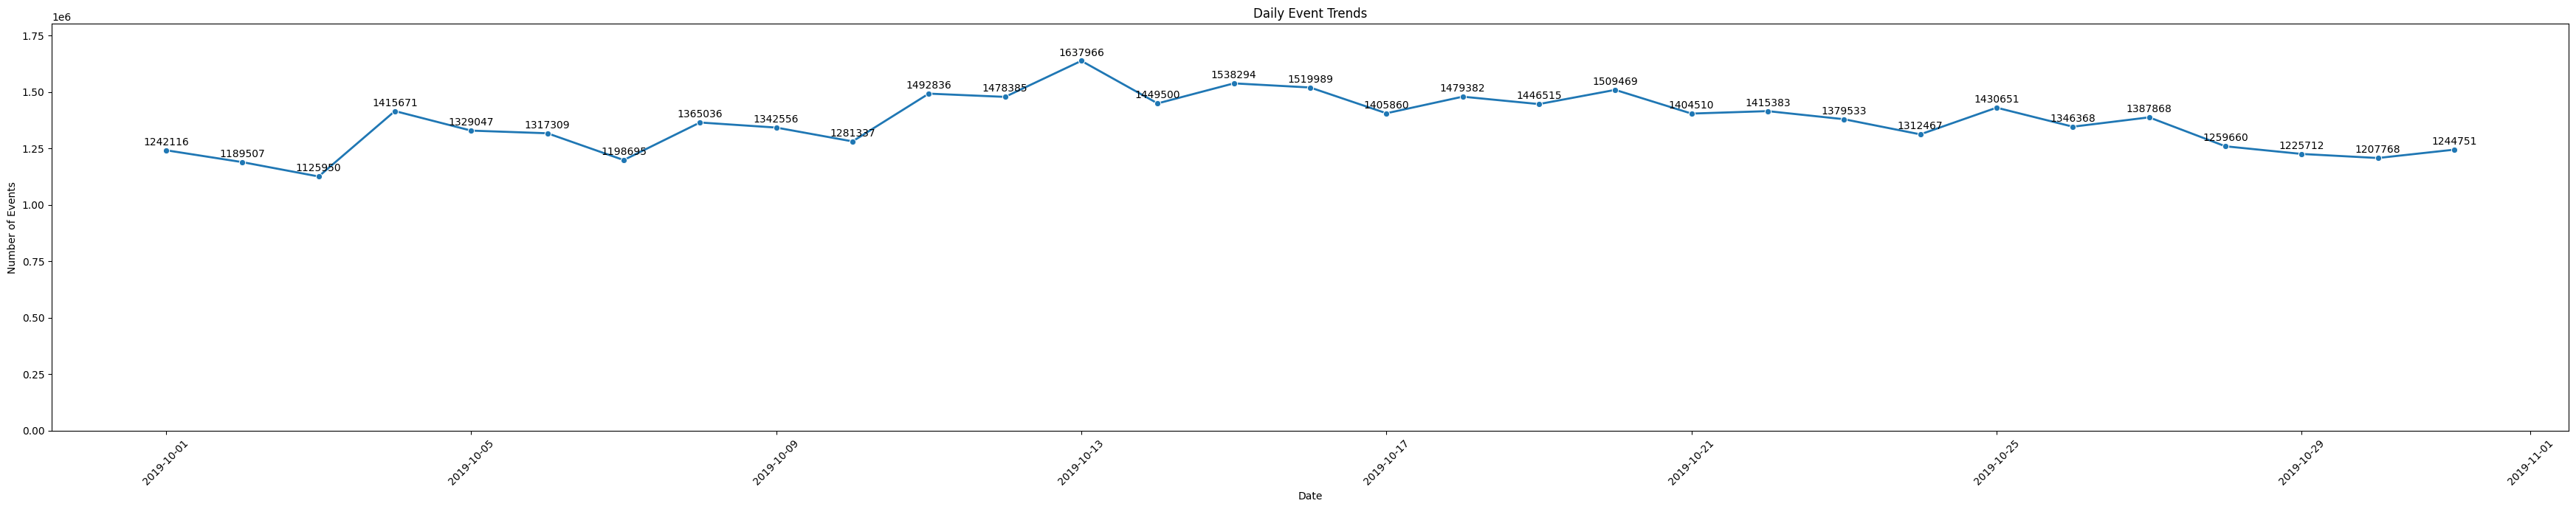

In [7]:
# --- Plot: Daily Event Trends ---
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
df['date'] = pd.to_datetime(df['event_time'].dt.date)
daily_counts = df.groupby('date').size().sort_index()
if not daily_counts.empty:
    plt.figure(figsize=(35, 7))
    if len(daily_counts) == 1:
        x = daily_counts.index.strftime('%Y-%m-%d')
        y = daily_counts.values
        ax = sns.barplot(x=x, y=y, color='tab:blue')
        plt.xlabel('Date')
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(int(height), (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=12, color='black')
    else:
        ax = sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker='o', linewidth=2)
        plt.xlabel('Date')
        for x_val, y_val in zip(daily_counts.index, daily_counts.values):
            ax.annotate(str(int(y_val)), xy=(x_val, y_val), xytext=(0, 5), textcoords='offset points', ha='center')
    plt.title('Daily Event Trends')
    plt.ylabel('Number of Events')
    plt.xticks(rotation=45)
    plt.ylim(0, daily_counts.max() * 1.1)
    plt.tight_layout()
    plt.show()
else:
    print('No daily event data to plot. Check if event_time is within expected range or if data is loaded correctly.')

Unique hours in data: 24
Unique sample hours: [ 3  0  1  2  9  4 10  5  6  7]
Unique sample hours: [ 3  0  1  2  9  4 10  5  6  7]


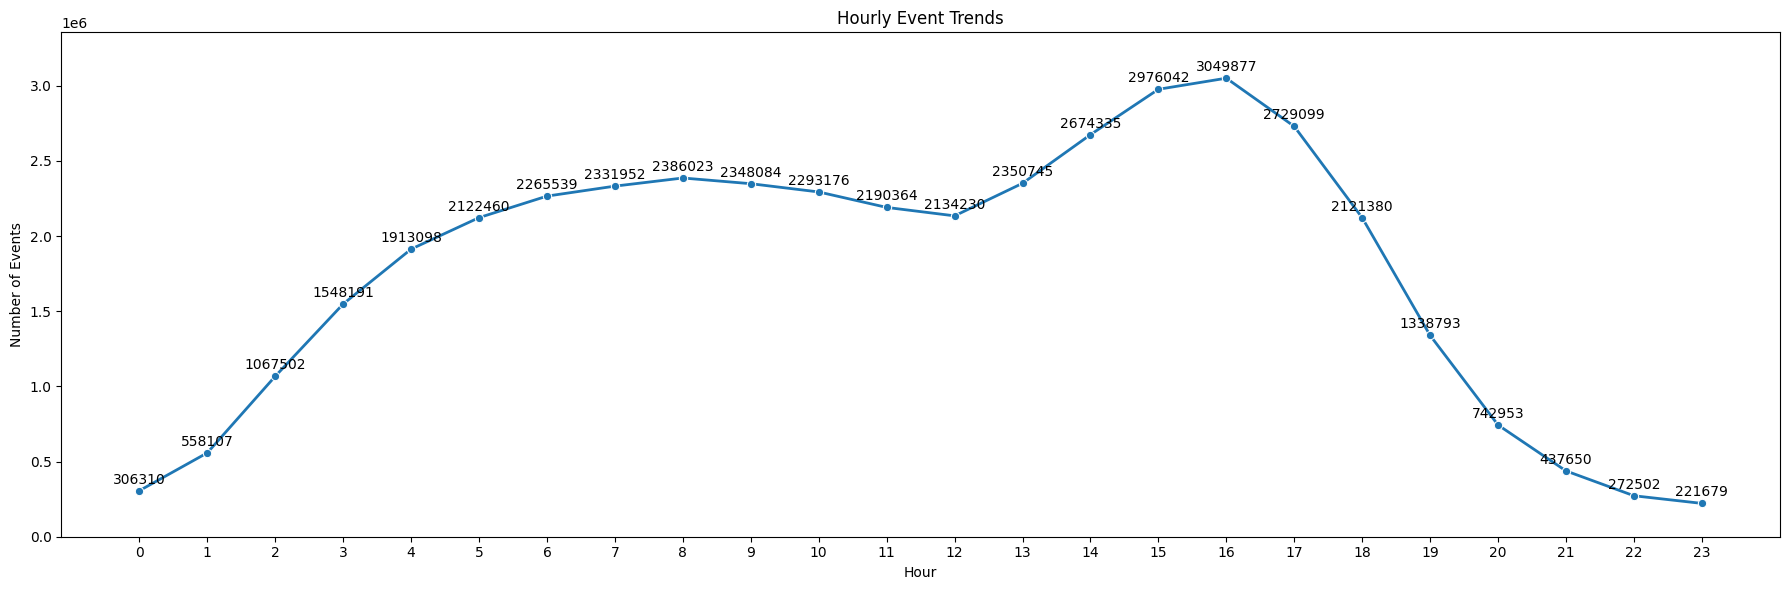

In [8]:
# --- Plot: Hourly Event Trends ---
print('Unique hours in data:', df['event_time'].dt.hour.nunique())
print('Unique sample hours:', df['event_time'].dt.hour.unique()[:10])
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
hourly_counts = df['event_time'].dt.hour.dropna().astype(int).value_counts().sort_index()
if not hourly_counts.empty:
    plt.figure(figsize=(18, 6))
    ax = sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', linewidth=2)
    plt.title('Hourly Event Trends')
    plt.xlabel('Hour')
    plt.ylabel('Number of Events')
    for x_val, y_val in zip(hourly_counts.index, hourly_counts.values):
        ax.annotate(str(int(y_val)), xy=(x_val, y_val), xytext=(0, 5), textcoords='offset points', ha='center')
    plt.xticks(range(0, 24))
    plt.ylim(0, max(hourly_counts.max() * 1.1, 1))
    plt.tight_layout()
    plt.show()
else:
    print('No hourly event data to plot. Check if event_time is within expected range or if data is loaded correctly.')